In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [86]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306384
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.230973
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.438139
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.959250
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.854156

Test set: Average loss: 0.0049, Accuracy: 8990/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.564575
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.659408
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.704415
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.483148
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.415692

Test set: Average loss: 0.0026, Accuracy: 9323/10000 (93%)



In [72]:
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [73]:
# for name, p in model.named_parameters():
#     try:
#         torch.nn.init.uniform_(p)
#         print(name + " randomed succesfully")
# #         test(model, device, test_loader)
#     except:
#         print(name)

In [82]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:101]

test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap_numpy_arr = []

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_numpy_arr.append(shap_numpy)

In [83]:
for i in range(4, -1, -1):
    try:
        torch.nn.init.uniform_(model.fc_layers[i].weight)
        print(model.fc_layers[i])
#         test(model, device, test_loader)
        e = shap.DeepExplainer(model, background)
        shap_values = e.shap_values(test_images)
        shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
        shap_numpy_arr.append(shap_numpy)
    except:
        pass

Linear(in_features=50, out_features=10, bias=True)
Linear(in_features=320, out_features=50, bias=True)


In [84]:
for i in range(6, -1, -1):
    try:
        torch.nn.init.uniform_(model.conv_layers[i].weight)
        print(model.conv_layers[i])
#         test(model, device, test_loader)
        e = shap.DeepExplainer(model, background)
        shap_values = e.shap_values(test_images)
        shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
        shap_numpy_arr.append(shap_numpy)
    except:
        pass
        

Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))


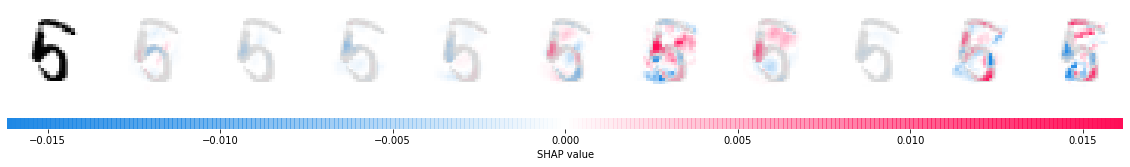

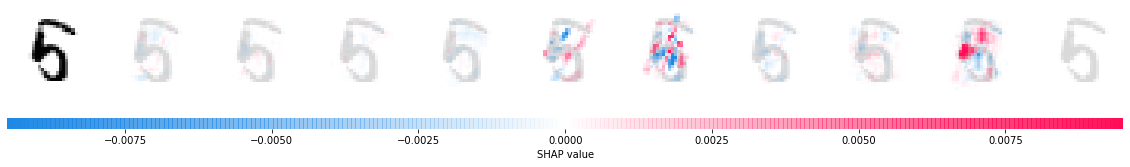

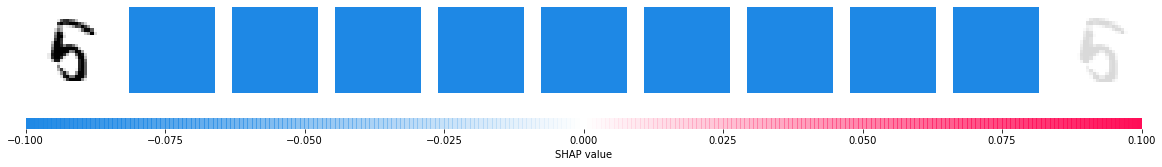

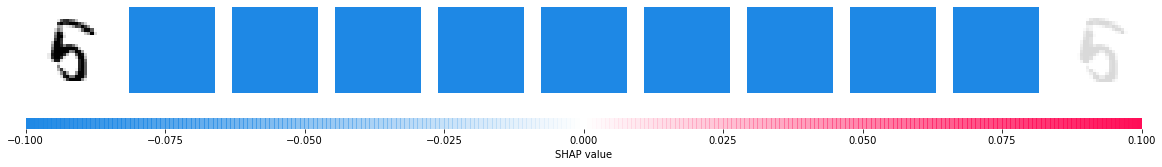

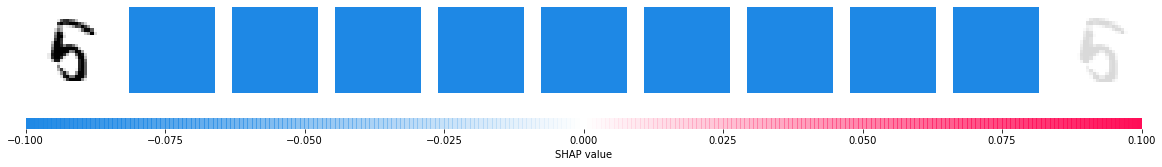

In [85]:
for sh in shap_numpy_arr:
    shap.image_plot(sh, -test_numpy)

In [22]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:101]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [23]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

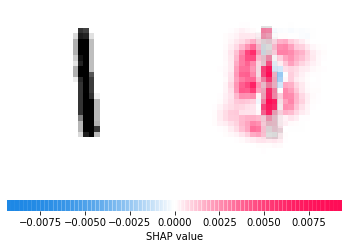

In [26]:
# plot the feature attributions
shap.image_plot(shap_numpy[1], -test_numpy)

In [24]:
def shuffle_train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        target = target[torch.randperm(target.size()[0])]
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [39]:
model_dummy = Net().to(device)
optimizer = optim.SGD(model_dummy.parameters(), lr=0.01, momentum=0.5)
for epoch in range(1, num_epochs + 1):
    train(model_dummy, device, train_loader, optimizer, epoch)
#     shuffle_train(model_dummy, device, train_loader, optimizer, epoch)
    test(model_dummy, device, test_loader)
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312475
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.261444
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.940622
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.960899
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.829740

Test set: Average loss: 0.0048, Accuracy: 8974/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.649182
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.456832
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.526418
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.444533
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.654658

Test set: Average loss: 0.0026, Accuracy: 9373/10000 (94%)



In [36]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:101]

e = shap.DeepExplainer(model_dummy, background)
shap_values = e.shap_values(test_images)

In [37]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

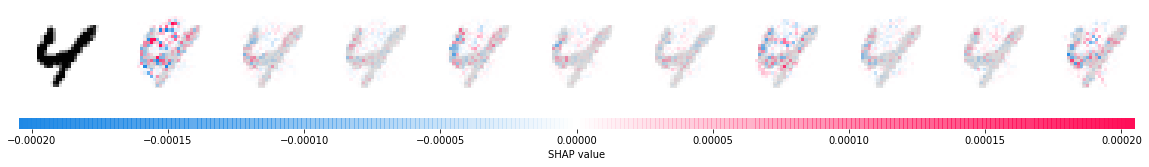

In [38]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

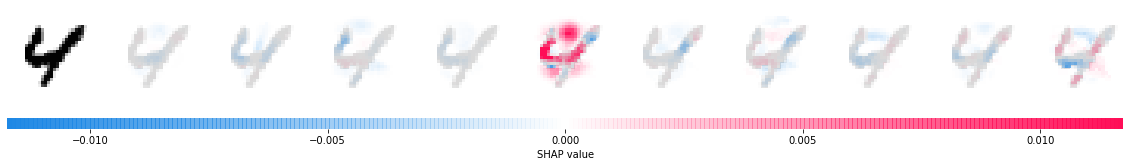

In [40]:
e = shap.DeepExplainer(model_dummy, background)
shap_values = e.shap_values(test_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)